Most of this is thanks to taking code written by https://hardiman-mostow.github.io/. Thanks!

In [1]:
import geopandas as gpd
from pathlib import Path
import yaml
import pandas as pd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
dist_events_repo = Path('/Users/cmarshak/bekaert-team/dist_s1_events/')
dist_events_repo

PosixPath('/Users/cmarshak/bekaert-team/dist_s1_events')

In [3]:
EVENT_NAME = 'chile_fire_2024'
TRACK_IDX = 0
POST_IDX = 0
PRE_POST_SEPARATION_DAYS = 0
PRE_EVENT_TEST_LOOKBACK = 28

# Directories

In [4]:
OUT_DIR = dist_events_repo / 'out'
OUT_DIR, OUT_DIR.exists()

(PosixPath('/Users/cmarshak/bekaert-team/dist_s1_events/out'), True)

In [5]:
EVENT_DATA = OUT_DIR / EVENT_NAME

In [6]:
RTC_DIR = EVENT_DATA / 'rtc_ts_merged'
DIST_HLS_CM_DIR = EVENT_DATA / 'change_map_dist_hls'
WATER_MASK_DIR = EVENT_DATA / 'water_mask'
VAL_DATA_DIR = EVENT_DATA / 'validation_data'
all([d.exists() for d in [RTC_DIR, DIST_HLS_CM_DIR, WATER_MASK_DIR, VAL_DATA_DIR]])

True

In [7]:
EVENT_DIR = dist_events_repo / 'events'
EVENT_DIR, EVENT_DIR.exists()

(PosixPath('/Users/cmarshak/bekaert-team/dist_s1_events/events'), True)

In [8]:
YML_DIR = dist_events_repo / 'events'
YML_DIR, YML_DIR.exists()

(PosixPath('/Users/cmarshak/bekaert-team/dist_s1_events/events'), True)

# Read Metadata

In [9]:
yaml_file = f'{EVENT_DIR}/{EVENT_NAME}.yml'
with open(yaml_file) as f:
    event_dict = yaml.safe_load(f)["event"]
event_dict

{'event_name': 'chile_fire_2024',
 'bounds': [-71.53071089, -33.20143816, -71.2964628, -32.98270579],
 'event_date': '2024-02-04',
 'pre_event_window_days': 180,
 'post_event_window_days': 100,
 'rtc_track_numbers': [18, 156],
 'mgrs_tiles': ['19HBD'],
 'source_id': 'EMSR715 AOI1',
 'dist_hls_confirmed_change_min_days': 30,
 'links': ['https://earthobservatory.nasa.gov/images/152411/fires-rage-in-central-chile',
  'https://en.wikipedia.org/wiki/2024_Chile_wildfires']}

In [10]:
EVENT_DATE = event_dict['event_date']
TRACKS = event_dict['rtc_track_numbers']

# Read Val Data

In [11]:
val_data_paths = list(VAL_DATA_DIR.glob('*.tif'))
aoi_path = [p for p in val_data_paths if 'extent_datamask' in p.stem][0]
val_path = [p for p in val_data_paths if 'extent' not in p.stem][0]

In [12]:
with rasterio.open(val_path) as ds:
    X_val = ds.read(1)
    p_val = ds.profile

In [13]:
with rasterio.open(aoi_path) as ds:
    X_aoi = ds.read(1)


# Water Mask

In [14]:
water_path = WATER_MASK_DIR / 'water_mask.tif'
water_path.exists()

True

In [15]:
with rasterio.open(water_path) as ds:
    X_water = ds.read(1)

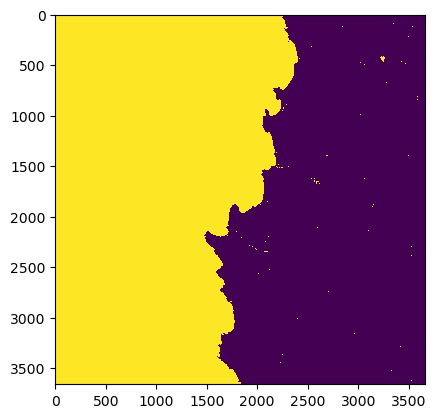

In [16]:
plt.imshow(X_water, interpolation='none')

# Read DIST HLS Change Map

In [17]:
assert len(list(DIST_HLS_CM_DIR.glob('*confirmed_change_map_gen*.tif'))) == 1
confirmed_gen_path = list(DIST_HLS_CM_DIR.glob('*confirmed_change_map_gen*.tif'))[0]

In [18]:
assert len(list(DIST_HLS_CM_DIR.glob('*confirmed_change_map_veg*.tif'))) == 1
confirmed_veg_path = list(DIST_HLS_CM_DIR.glob('*confirmed_change_map_veg*.tif'))[0]

In [19]:
with rasterio.open(confirmed_veg_path) as ds:
    X_con_veg = ds.read(1)

In [20]:
with rasterio.open(confirmed_gen_path) as ds:
    X_con_gen = ds.read(1)

In [21]:
#plt.imshow(X_con_veg)

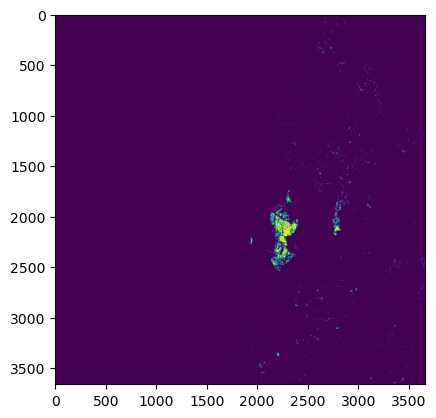

In [22]:
plt.imshow(X_con_gen)

# Read RTC data

In [23]:
track = TRACKS[TRACK_IDX]
merged_dir = RTC_DIR / f'track{track}'
merged_dir.exists()

True

In [24]:
vv_paths = sorted(list(merged_dir.glob('*VV.tif')))
vh_paths = sorted(list(merged_dir.glob('*VH.tif')))
acq_dts = [pd.Timestamp(p.stem.split('_')[1]) for p in vh_paths]
event_date = pd.Timestamp(event_dict['event_date']) 
acq_dts[:3], vh_paths[:3]

([Timestamp('2023-11-01 00:00:00'),
  Timestamp('2023-11-13 00:00:00'),
  Timestamp('2023-11-25 00:00:00')],
 [PosixPath('/Users/cmarshak/bekaert-team/dist_s1_events/out/chile_fire_2024/rtc_ts_merged/track18/merged_2023-11-01_track18_VH.tif'),
  PosixPath('/Users/cmarshak/bekaert-team/dist_s1_events/out/chile_fire_2024/rtc_ts_merged/track18/merged_2023-11-13_track18_VH.tif'),
  PosixPath('/Users/cmarshak/bekaert-team/dist_s1_events/out/chile_fire_2024/rtc_ts_merged/track18/merged_2023-11-25_track18_VH.tif')])

In [25]:
event_date

Timestamp('2024-02-04 00:00:00')

## Setup 2nd set

In [26]:
event_date_2 = event_date - pd.Timedelta(days=PRE_EVENT_TEST_LOOKBACK)
event_date, event_date_2

(Timestamp('2024-02-04 00:00:00'), Timestamp('2024-01-07 00:00:00'))

In [27]:
dates_pre = [acq_dt for acq_dt in acq_dts if acq_dt < event_date - pd.Timedelta(days = PRE_POST_SEPARATION_DAYS)]
dates_pre

[Timestamp('2023-11-01 00:00:00'),
 Timestamp('2023-11-13 00:00:00'),
 Timestamp('2023-11-25 00:00:00'),
 Timestamp('2023-12-07 00:00:00'),
 Timestamp('2023-12-19 00:00:00'),
 Timestamp('2023-12-31 00:00:00'),
 Timestamp('2024-01-12 00:00:00'),
 Timestamp('2024-01-24 00:00:00')]

In [28]:
dates_pre_2 = [acq_dt for acq_dt in acq_dts if acq_dt < event_date_2 - pd.Timedelta(days = PRE_POST_SEPARATION_DAYS)]
dates_pre_2

[Timestamp('2023-11-01 00:00:00'),
 Timestamp('2023-11-13 00:00:00'),
 Timestamp('2023-11-25 00:00:00'),
 Timestamp('2023-12-07 00:00:00'),
 Timestamp('2023-12-19 00:00:00'),
 Timestamp('2023-12-31 00:00:00')]

## Paths for RTC

In [29]:
vv_paths_pre_all = [p for (p, dt) in zip(vv_paths, acq_dts) if dt < event_date - pd.Timedelta(days = PRE_POST_SEPARATION_DAYS)]
vh_paths_pre_all = [p for (p, dt) in zip(vh_paths, acq_dts) if dt < event_date - pd.Timedelta(days = PRE_POST_SEPARATION_DAYS)]

In [30]:
vv_paths_pre_all_2 = [p for (p, dt) in zip(vv_paths, acq_dts) if dt < event_date_2 - pd.Timedelta(days = PRE_POST_SEPARATION_DAYS)]
vh_paths_pre_all_2 = [p for (p, dt) in zip(vh_paths, acq_dts) if dt < event_date_2 - pd.Timedelta(days = PRE_POST_SEPARATION_DAYS)]

In [31]:
vv_paths_post_all = [p for (p, dt) in zip(vv_paths, acq_dts) if dt >= event_date]
vh_paths_post_all = [p for (p, dt) in zip(vh_paths, acq_dts) if dt >= event_date]

In [32]:
vv_paths_post_all_2 = [p for (p, dt) in zip(vv_paths, acq_dts) if dt >= event_date_2]
vh_paths_post_all_2 = [p for (p, dt) in zip(vh_paths, acq_dts) if dt >= event_date_2]

In [33]:
def open_one_arr(path: Path) -> np.ndarray:
    with rasterio.open(path) as ds:
        X = ds.read(1)
    X[X_water.astype(bool)] = np.nan
    return X

In [34]:
pre_vv = [open_one_arr(path) for path in vv_paths_pre_all]
pre_vh = [open_one_arr(path) for path in vh_paths_pre_all]

In [35]:
pre_vv_2 = [open_one_arr(path) for path in vv_paths_pre_all_2]
pre_vh_2 = [open_one_arr(path) for path in vh_paths_pre_all_2]

In [36]:
len(pre_vh_2), len(pre_vh)

(6, 8)

In [37]:
def rolling_average(xs: list[np.ndarray], n=2):
    """source: https://stackoverflow.com/a/14314054"""
    X = np.stack(xs, axis=0)
    ret = np.nancumsum(X, axis=0)
    ret[n:, ...] = ret[n:, ...] - ret[:-n, ...]
    out = ret[n - 1:, ...] / n
    out_l = [x for x in out]
    return out_l

In [38]:
def logit(x):
    frac = (x + 1e-7) / (1 - x - 1e-7)
    return np.log(frac)

In [39]:
# pre_vh_logits = [logit(x) for x in pre_vh]
# pre_vv_logits = [logit(x) for x in pre_vv]

In [40]:
# pre_vh_rolling = rolling_average(pre_vh)
# pre_vv_rolling = rolling_average(pre_vv)

In [41]:
post_vv = [open_one_arr(path) for path in vv_paths_post_all[POST_IDX:POST_IDX + 1]][0]
post_vh = [open_one_arr(path) for path in vh_paths_post_all[POST_IDX:POST_IDX + 1]][0]

In [42]:
post_vv_2 = [open_one_arr(path) for path in vv_paths_post_all_2[POST_IDX:POST_IDX + 1]][0]
post_vh_2 = [open_one_arr(path) for path in vh_paths_post_all_2[POST_IDX:POST_IDX + 1]][0]

In [43]:
len(vv_paths_post_all), len(vv_paths_post_all_2)

(5, 7)

In [44]:
def diff_metric(pre: list, 
                post: list,
                window_size: int = 1,
                qual_stat: str ='median') -> np.ndarray:
    if window_size == 1:
        stack = np.stack(pre, axis=0)
        if qual_stat == 'median':
            stat = np.nanmedian
        elif qual_stat == 'mean':
            stat == np.nanmean
        pre_stat = stat(stack, axis=0)
        diff = 10 * np.log10(post) - 10 * np.log10(pre_stat)
    else:
        raise NotImplementedError
        
    return diff



In [45]:
metric_vh = diff_metric(pre_vh, post_vh)
metric_vh_2 = diff_metric(pre_vh_2, post_vh_2) 

/var/folders/0p/d5x2m4tx5kg1246bplsvyfyh0000gq/T/ipykernel_81334/3858312585.py:11: RuntimeWarning: All-NaN slice encountered
  pre_stat = stat(stack, axis=0)


In [46]:
def diff_change_crit(metric: np.ndarray, threshold_ub: float = -6) -> np.ndarray:
    return (metric < threshold_ub).astype(np.uint8)

In [47]:
cm = diff_change_crit(metric_vh)
cm_2 = diff_change_crit(metric_vh_2) 

<>:13: SyntaxWarning: invalid escape sequence '\g'
<>:13: SyntaxWarning: invalid escape sequence '\g'
/var/folders/0p/d5x2m4tx5kg1246bplsvyfyh0000gq/T/ipykernel_81334/2351343073.py:13: SyntaxWarning: invalid escape sequence '\g'
  cb.ax.set_ylabel('$\gamma$ diff')


Text(0, 0.5, '$\\gamma$ diff')

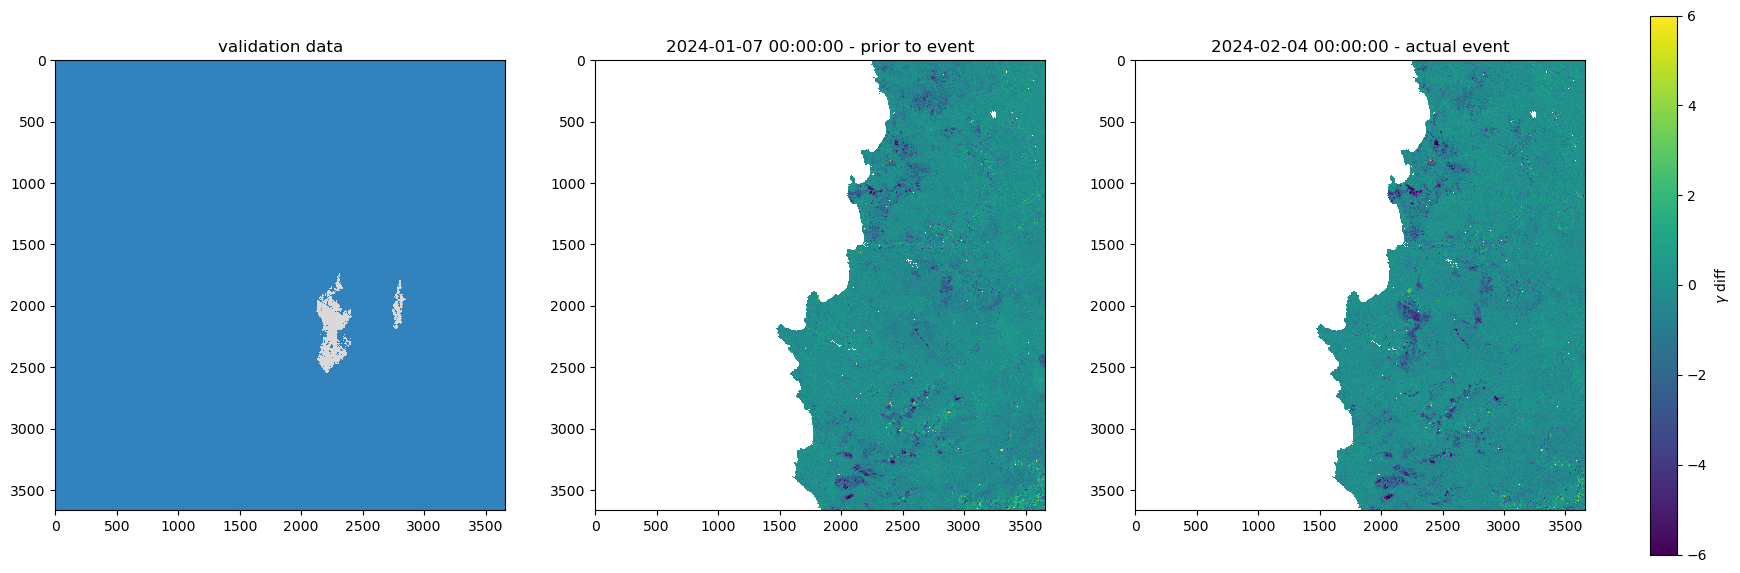

In [48]:
fig, ax = plt.subplots(1, 3, figsize=(21, 7))

ax[0].imshow(X_val, vmin=0, vmax=1, cmap='tab20c', interpolation='none')
ax[0].set_title('validation data')

ax[1].imshow(metric_vh_2, vmin=-6, vmax=6, interpolation='none')
ax[1].set_title(f'{event_date_2} - prior to event')

im = ax[2].imshow(metric_vh,  vmin=-6, vmax=6, interpolation='none')
ax[2].set_title(f'{event_date} - actual event')

cb = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cb.ax.set_ylabel('$\gamma$ diff')

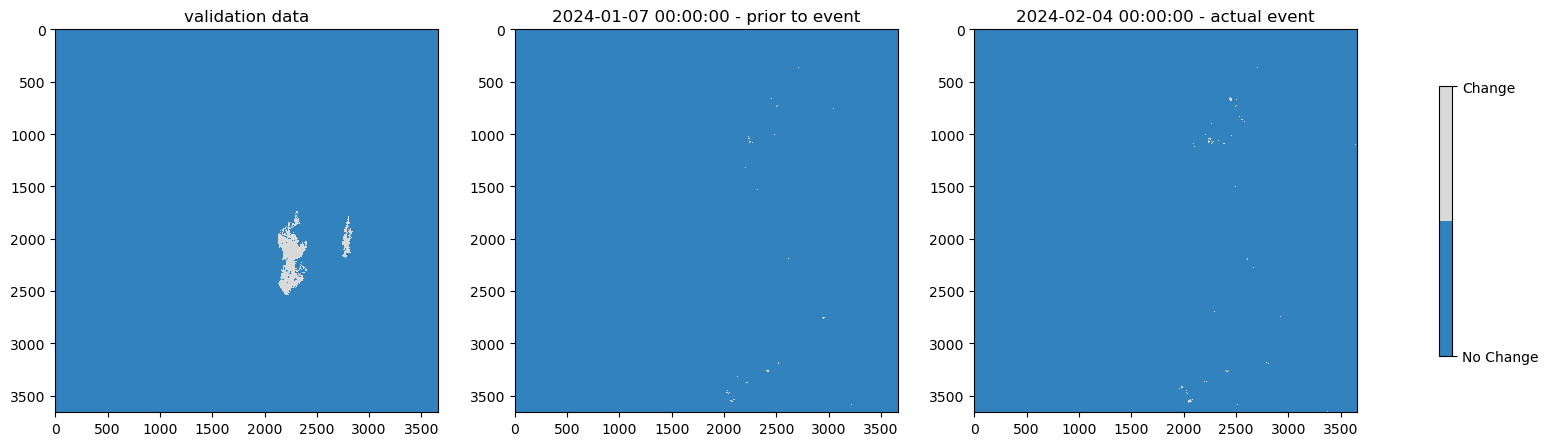

In [49]:
fig, ax = plt.subplots(1, 3, figsize=(21, 7))

bounds =  [0, 1]
ticks = [-0.5, 1.5]
tick_labels = ['No Change',
               'Change'
             ]

bounds = [-0.5, 0.5, 1.5]  # Define the boundaries between 0 and 1

ax[0].imshow(X_val, vmin=0, vmax=1, cmap='tab20c', interpolation='none')
ax[0].set_title('validation data')

ax[1].imshow(cm_2, vmin=0, vmax=1, interpolation='none', cmap='tab20c')
ax[1].set_title(f'{event_date_2} - prior to event')

im = ax[2].imshow(cm, vmin=0, vmax=1, interpolation='none', cmap='tab20c')
ax[2].set_title(f'{event_date} - actual event')

cb =fig.colorbar(im, 
                  ax=ax, 
                  shrink=0.5, 
                  pad=0.05, 
                  boundaries=bounds, 
                  ticks=ticks) 
cb.set_ticklabels(tick_labels) 

# Acq Count

In [50]:
X_acq_count = ((np.stack(pre_vh, axis=0) >= 0).sum(axis=0))

In [51]:
M = np.nanmax(X_acq_count)
M

8

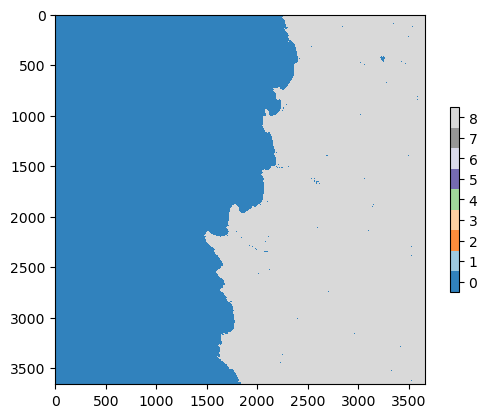

In [52]:
fig, ax = plt.subplots()

# Use the 'tab20c' colormap
cmap = plt.get_cmap('tab10')

# Define boundaries for integer values (0, 1, 2, 3)
bounds = np.arange(M + 2) - .5
tick_labels = list(range(0, M+1))
ticks =  [k for k in np.arange(M+1)]

im = ax.imshow(X_acq_count, cmap='tab20c', interpolation='none', vmin=0, vmax=M)
cb =fig.colorbar(im, 
                  ax=ax, 
                  shrink=0.5, 
                  pad=0.05, 
                  boundaries=bounds, 
                  ticks=ticks) 
cb.set_ticklabels(tick_labels)


# AOI Validation Data

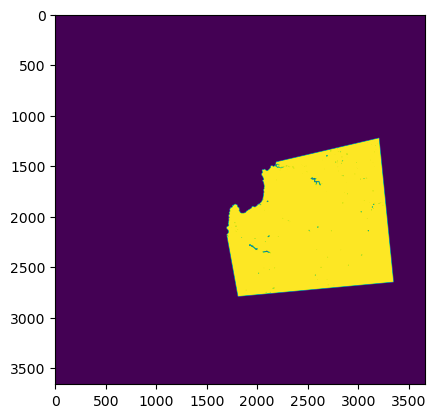

In [53]:
aoi_mask = X_aoi.astype(bool) & (~np.isnan(metric_vh))

plt.imshow(aoi_mask)

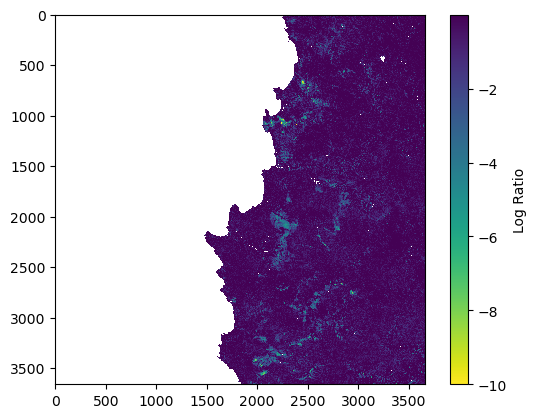

In [54]:
metric_vh_t = np.clip(metric_vh, -10, -1e-5)
metric_vh_t2 = np.clip(metric_vh_2, -10, -1e-5)


plt.imshow(metric_vh_t, interpolation='none', cmap='viridis_r')
plt.colorbar(label='Log Ratio')

In [56]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, f1_score

#dist_hls_f1_v_val = f1_score(change_val

metric_aoi = metric_vh_t[aoi_mask]
metric_aoi2 = metric_vh_t2[aoi_mask]
metric_aoi_con = np.concatenate([metric_aoi, metric_aoi2], axis=0)

change_val = X_val[aoi_mask]
change_val2 = np.zeros(change_val.shape)
change_val_con = np.concatenate([change_val, change_val2], axis=0)

dist_hls_f1_v_val = f1_score(change_val, X_con_gen[aoi_mask])


precisions, recalls, thresholds = precision_recall_curve(change_val_con, -metric_aoi_con)

f1_scores = 2 * recalls * precisions / (recalls + precisions + 1e-7)
k_max = np.argmax(f1_scores)
f1_max = f1_scores[k_max]

<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
/var/folders/0p/d5x2m4tx5kg1246bplsvyfyh0000gq/T/ipykernel_81334/2600215225.py:8: SyntaxWarning: invalid escape sequence '\m'
  plt.annotate(f'$\max(F_1)=${f1_max:1.2f}', (recalls[k_max] + .01, precisions[k_max] + .01))


Text(0.44076200382511826, 0.33694119744314566, '$\\max(F_1)=$0.37')

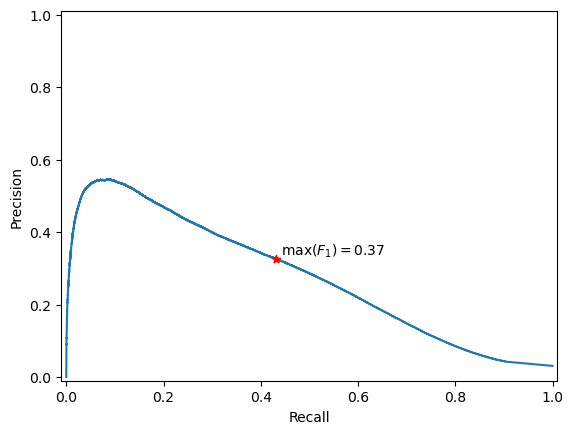

In [57]:
plt.plot(recalls[:-1], precisions[:-1])
plt.xlim(-0.01, 1.01)
plt.ylim(-.01, 1.01)
plt.ylabel('Precision')
plt.xlabel('Recall')

plt.scatter(recalls[k_max], precisions[k_max], marker='*', c='red', zorder=2)
plt.annotate(f'$\max(F_1)=${f1_max:1.2f}', (recalls[k_max] + .01, precisions[k_max] + .01))

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
/var/folders/0p/d5x2m4tx5kg1246bplsvyfyh0000gq/T/ipykernel_81334/605204746.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.annotate(f'$\max(F_1)=${f1_max:1.2f}', (thresholds[k_max] + .001, f1_scores[k_max] + .001))


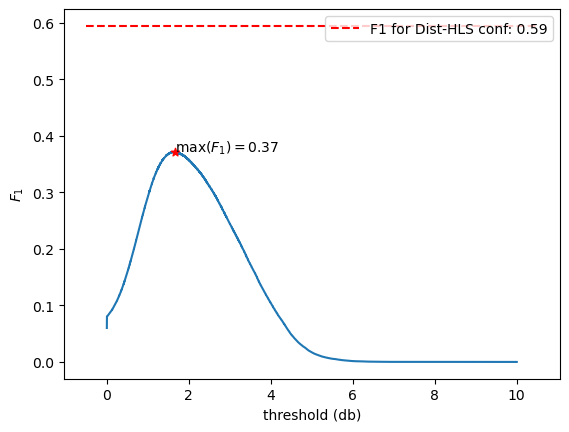

In [58]:
plt.plot(thresholds, f1_scores[:-1])
plt.scatter(thresholds[k_max], f1_scores[k_max], marker='*', c='red', zorder=2)
plt.annotate(f'$\max(F_1)=${f1_max:1.2f}', (thresholds[k_max] + .001, f1_scores[k_max] + .001))
plt.title('')
plt.ylabel('$F_1$')
plt.xlabel('threshold (db)')
ax = plt.gca()
xlim = ax.get_xlim()
plt.hlines(dist_hls_f1_v_val, *xlim, color='red', linestyles='--', label=f'F1 for Dist-HLS conf: {dist_hls_f1_v_val:1.2f}')
plt.legend()

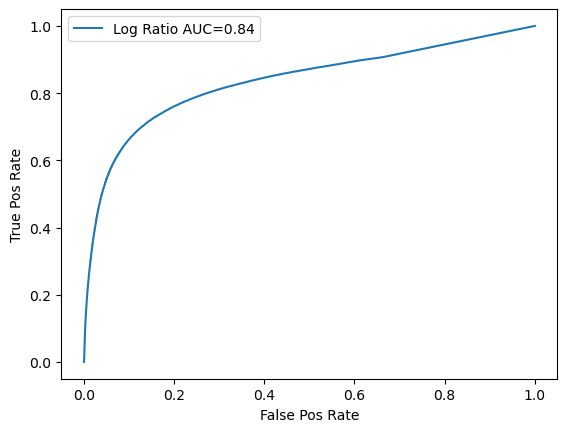

In [59]:
fprs, tprs, _ = roc_curve(change_val_con, -metric_aoi_con)

auc = roc_auc_score(change_val_con, -metric_aoi_con)

plt.plot(fprs, tprs, label=f'Log Ratio AUC={auc:1.2f}')
plt.xlabel('False Pos Rate')
plt.ylabel('True Pos Rate')
plt.legend()

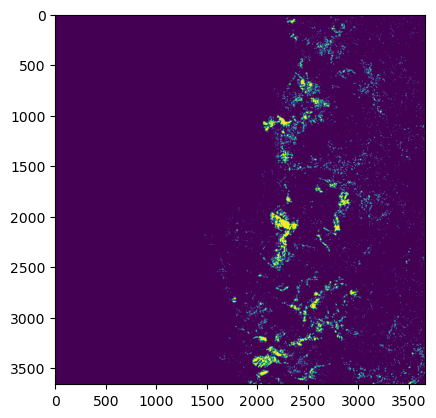

In [60]:
plt.imshow(metric_vh < -thresholds[k_max])

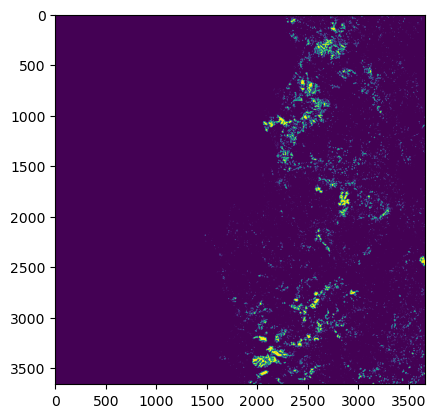

In [61]:
plt.imshow(metric_vh_2 < -thresholds[k_max])

# DIST-HLS vs RTC Change

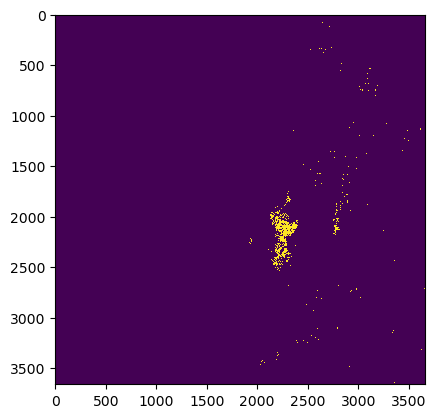

In [62]:
plt.imshow(X_con_gen, interpolation='none')

In [63]:
X_dist_cm = X_con_gen
dist_hls_mask = ~np.isnan(metric_vh) 

In [64]:
from sklearn.metrics import precision_recall_curve, roc_curve

metric_dist = metric_vh_t[dist_hls_mask]

change_dist = X_dist_cm[dist_hls_mask]
precisions, recalls, thresholds = precision_recall_curve(change_dist, -metric_dist)

f1_scores = 2 * recalls * precisions / (recalls + precisions + 1e-7)
k_max = np.argmax(f1_scores)
f1_max = f1_scores[k_max]

<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
/var/folders/0p/d5x2m4tx5kg1246bplsvyfyh0000gq/T/ipykernel_81334/2600215225.py:8: SyntaxWarning: invalid escape sequence '\m'
  plt.annotate(f'$\max(F_1)=${f1_max:1.2f}', (recalls[k_max] + .01, precisions[k_max] + .01))


Text(0.38498067109942785, 0.18228028047940098, '$\\max(F_1)=$0.24')

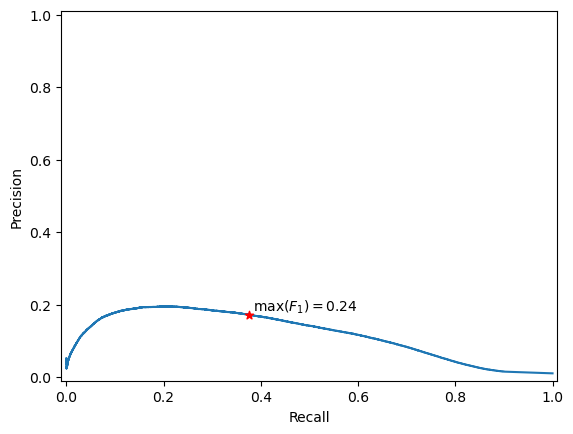

In [65]:
plt.plot(recalls[:-1], precisions[:-1])
plt.xlim(-0.01, 1.01)
plt.ylim(-.01, 1.01)
plt.ylabel('Precision')
plt.xlabel('Recall')

plt.scatter(recalls[k_max], precisions[k_max], marker='*', c='red', zorder=2)
plt.annotate(f'$\max(F_1)=${f1_max:1.2f}', (recalls[k_max] + .01, precisions[k_max] + .01))